# Sentencing Analysis

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", None)


In [3]:
# load data

chunksize = 1000000
case_off_chunk = pd.read_csv(
    "/Users/htyun/Documents/Duke MIDS/Capstone/JUSTFAIR_capstone/10_clean_data/case_offense_v01.csv",
    low_memory=False,
    chunksize=chunksize,
    iterator=True,
)
case_off = pd.concat(case_off_chunk, ignore_index=True)


In [4]:
offence_codes = pd.read_csv(
    "/Users/htyun/Documents/Duke MIDS/Capstone/JUSTFAIR_capstone/00_raw_data/ACIS_offence_codes.csv"
)


In [5]:
# merge with offense class to get offense class of charged offense code
cases_codes = pd.merge(
    case_off,
    offence_codes,
    left_on=["convicted_offense_code", "offense_class"],
    right_on=["CODE", "CL"],
    how="left",
    validate="m:m",
    indicator=True,
)


In [6]:
# Substetting for cases that have a charge code (most do)
cases_w_charges = cases_codes.loc[~cases_codes["charged_offense_code"].isna()]


In [7]:
# Substetting for cases that have a convicted code
cases_w_sent_code = cases_w_charges.loc[
    ~cases_w_charges["convicted_offense_code"].isna()
]


In [8]:
cases_w_sent_code["disposition"].value_counts(normalize=True, dropna=False) * 100
# be midnful: WC and WM basically mean that the defendant waived their right to trial (in front of a judge) and plead guilty
cases_w_sent_code["went_to_trial"] = 0
cases_w_sent_code.loc[
    cases_w_sent_code["disposition"].isin(["JU", "JR"]), "went_to_trial"
] = 1


/var/folders/xg/_ky8jfkd3j76k5khyx2bgk6h0000gn/T/ipykernel_55211/42591767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_w_sent_code['went_to_trial'] = 0


In [123]:
(cases_w_sent_code.shape[0] - cases_ready_chart.shape[0]) / cases_w_sent_code.shape[
    0
] * 100  # 78% (only 22% of convicted cases have prior record AND min sentence)

(cases_w_charges.shape[0] - cases_ready_chart.shape[0]) / cases_w_charges.shape[
    0
] * 100  # 94.74 of cases dont have min_sentence, prior_record, or charges


94.74966019086257

In [ ]:
# Check whether the sentences are given only to the cases that have a "convicted offence code" (funnel)
cases_ready_chart = cases_w_sent_code.loc[~cases_w_sent_code["min_sentence_day"].isna()]
cases_ready_chart = cases_ready_chart.loc[
    ~cases_ready_chart["prior_record_points"].isna()
]
cases_ready_chart = cases_ready_chart[
    [
        "case_id",
        "key_county_num",
        "race",
        "sex",
        "went_to_trial",
        "convicted_offense_code",
        "charged_offense_date",
        "plea_code",
        "verdict_code",
        "disposition",
        "prior_record_points",
        "offense_class",
        "CL",
        "Offense Description",
        "min_sentence_day",
        "max_sentence_day",
    ]
]
#cases_ready_chart


In [10]:
# create a column to indicate felony/misdemeanor

offense = cases_ready_chart
offense["offense_type"] = "Felony"
offense.loc[
    offense["offense_class"].isin(["1", "2", "3", "A1"]), "offense_type"
] = "Misdemeanor"


In [11]:
# code prior points
offense["prior_points_range"] = 0
offense.loc[
    (offense["offense_type"] == "Felony")
    & (offense["prior_record_points"] >= 0)
    & (offense["prior_record_points"] <= 1),
    "prior_points_range",
] = 1
offense.loc[
    (offense["offense_type"] == "Felony")
    & (offense["prior_record_points"] >= 2)
    & (offense["prior_record_points"] <= 5),
    "prior_points_range",
] = 2
offense.loc[
    (offense["offense_type"] == "Felony")
    & (offense["prior_record_points"] >= 6)
    & (offense["prior_record_points"] <= 9),
    "prior_points_range",
] = 3
offense.loc[
    (offense["offense_type"] == "Felony")
    & (offense["prior_record_points"] >= 10)
    & (offense["prior_record_points"] <= 13),
    "prior_points_range",
] = 4
offense.loc[
    (offense["offense_type"] == "Felony")
    & (offense["prior_record_points"] >= 14)
    & (offense["prior_record_points"] <= 17),
    "prior_points_range",
] = 5
offense.loc[
    (offense["offense_type"] == "Felony") & (offense["prior_record_points"] >= 18),
    "prior_points_range",
] = 6
offense.loc[
    (offense["offense_type"] == "Misdemeanor")
    & (offense["prior_record_points"] >= 1)
    & (offense["prior_record_points"] <= 4),
    "prior_points_range",
] = 2
offense.loc[
    (offense["offense_type"] == "Misdemeanor") & (offense["prior_record_points"] == 0),
    "prior_points_range",
] = 1
offense.loc[
    (offense["offense_type"] == "Misdemeanor") & (offense["prior_record_points"] >= 5),
    "prior_points_range",
] = 3


In [12]:
# remove duplicates
offense = offense.groupby(["case_id", "convicted_offense_code"]).first().reset_index()


In [ ]:
# load sentencing grid
sentencing_grid = pd.read_csv(
    "/Users/htyun/Documents/Duke MIDS/Capstone/JUSTFAIR_capstone/10_clean_data/punishment_grid_db.csv"
)

In [ ]:
for index, row in sentencing_grid.iterrows():
    if (row["sg_disposition"] == "Presumptive") or (
        row["sg_disposition"] == "Aggravated"
    ):
        sentencing_grid.loc[index, "sg_MIN_min"] = (
            sentencing_grid.loc[index, "sg_MIN_min"] + 1
        )


In [34]:
# merge
grid = pd.merge(
    offense,
    sentencing_grid,
    how="left",
    left_on=["offense_type", "offense_class", "prior_points_range"],
    right_on=["crime_type", "sg_class", "sg_prior_record_level"],
    validate="m:m",
    indicator=True,
)

# after merge, one felony case should has 3 rows (mitigated, presumptive, aggravated)
grid._merge.value_counts()


both          1825232
left_only           5
right_only          0
Name: _merge, dtype: int64

In [ ]:
grid["MIN_min_diff"] = grid["min_sentence_day"] - grid["sg_MIN_min"]
grid["MIN_max_diff"] = grid["min_sentence_day"] - grid["sg_MIN_max"]


In [ ]:
# Fit cases into SUB boxes of the sentencing grid

# To determine which range does the case fall into:
# the range that the case falls into should have this property:  min_sentence_length-sg_MIN_min >= 0 & min_sentence_length-sg_MIN_max <= 0
# only one of the three ranges may have above property if the sentencing length is at least following the grid

##### EDGE CASES - CASES FOLLOWING ON THE MIN/MAX OF THE GRID RANGE -> CLASSIFY INTO LENIER RANGE

grid["MIN_sentence_allocated_correctly"] = 0
grid.loc[
    (grid["MIN_min_diff"] >= 0) & (grid["MIN_max_diff"] <= 0),
    "MIN_sentence_allocated_correctly",
] = 1
#grid


In [37]:
offense["offense_type"].value_counts()


Misdemeanor    879602
Felony         315215
Name: offense_type, dtype: int64

In [ ]:
# Check proportion of cases that follow the rulesss
correct_allocations = grid.loc[
    grid["MIN_sentence_allocated_correctly"] == 1
]  # checked: no duplicates
len(correct_allocations) / len(offense)


In [42]:
# subset correct_allocations columns
correct_allocations_sub = correct_allocations[
    [
        "case_id",
        "convicted_offense_code",
        "sg_class",
        "sg_disposition",
        "sg_MIN_min",
        "sg_MIN_max",
        "sg_punishment",
        "severity_rank",
        "sg_MAX_min",
        "sg_MAX_max",
        "MIN_min_diff",
        "MIN_max_diff",
        "MIN_sentence_allocated_correctly",
    ]
]


In [43]:
all_df = pd.merge(
    offense,
    correct_allocations_sub,
    on=["case_id", "convicted_offense_code"],
    how="left",
    indicator=True,
)
all_df._merge.value_counts()


both          1123969
left_only       70848
right_only          0
Name: _merge, dtype: int64

In [46]:
# for felony cases that fall out of the ranges, determine whether they are under-sentencing or over-sentencing
incorrect_allocations = grid.loc[grid["MIN_sentence_allocated_correctly"] == 0]

felony_under = incorrect_allocations[
    (incorrect_allocations["sg_disposition"] == "Mitigated")
    & (incorrect_allocations["MIN_min_diff"] < 0)
]
felony_under["sg_disposition"] = "< Minimum"
felony_over = incorrect_allocations[
    (incorrect_allocations["sg_disposition"] == "Aggravated")
    & (incorrect_allocations["MIN_max_diff"] > 0)
]
felony_over["sg_disposition"] = "> Maximum"
misdemeanor_under = incorrect_allocations[
    (incorrect_allocations["offense_type"] == "Misdemeanor")
    & (incorrect_allocations["MIN_min_diff"] < 0)
]
misdemeanor_under["sg_disposition"] = "< Minimum"
misdemeanor_over = incorrect_allocations[
    (incorrect_allocations["offense_type"] == "Misdemeanor")
    & (incorrect_allocations["MIN_min_diff"] > 0)
]
misdemeanor_over["sg_disposition"] = "> Maximum"


/var/folders/xg/_ky8jfkd3j76k5khyx2bgk6h0000gn/T/ipykernel_55211/4153444112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  felony_under['sg_disposition'] = "< Minimum"
/var/folders/xg/_ky8jfkd3j76k5khyx2bgk6h0000gn/T/ipykernel_55211/4153444112.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  felony_over['sg_disposition'] = "> Maximum"
/var/folders/xg/_ky8jfkd3j76k5khyx2bgk6h0000gn/T/ipykernel_55211/4153444112.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [ ]:
#  combine all cases

misdemeanor_correct = correct_allocations[
    correct_allocations["offense_type"] == "Misdemeanor"
]
felony_correct = correct_allocations[correct_allocations["offense_type"] == "Felony"]
all_offense = pd.concat(
    [
        felony_correct,
        felony_over,
        felony_under,
        misdemeanor_correct,
        misdemeanor_over,
        misdemeanor_under,
    ]
)
#all_offense


In [66]:
# distribution of sentencing ranges
all_offense["sg_disposition"].value_counts(normalize=True)


Presumptive    0.477794
Mitigated      0.302742
> Maximum      0.185038
Aggravated     0.029017
< Minimum      0.005409
Name: sg_disposition, dtype: float64

In [53]:
all_offense["race"].value_counts(normalize=True) * 100


W    49.908646
B    43.484010
H     3.175910
I     1.795269
O     0.741542
U     0.648640
A     0.245897
X     0.000084
Name: race, dtype: float64

In [55]:
all_offense[all_offense["sg_disposition"] == "> Maximum"]["race"].value_counts(
    normalize=True
) * 100


W    47.115915
B    45.410165
H     3.630895
I     2.268038
U     0.691599
O     0.688693
A     0.194694
Name: race, dtype: float64

### For Felony cases that are over-sentenced, the percentage of black defendants are dispropotionately higher

In [71]:
all_offense[
    (all_offense["sg_disposition"] == "> Maximum")
    & (all_offense["offense_type"] == "Felony")
]["race"].value_counts(normalize=True) * 100


B    51.938049
W    41.080007
H     4.580089
I     0.935895
U     0.737121
O     0.505218
A     0.223621
Name: race, dtype: float64

In [56]:
all_offense[all_offense["race"] == "B"]["sg_disposition"].value_counts(
    normalize=True
) * 100


Presumptive    44.958402
Mitigated      32.773089
> Maximum      18.760580
Aggravated      2.923875
< Minimum       0.584055
Name: sg_disposition, dtype: float64

In [57]:
all_offense[all_offense["race"] == "W"]["sg_disposition"].value_counts(
    normalize=True
) * 100


Presumptive    50.935766
Mitigated      28.151477
> Maximum      17.555694
Aggravated      2.859540
< Minimum       0.497523
Name: sg_disposition, dtype: float64

In [165]:
disposition = all_offense["sg_disposition"].value_counts(normalize=True).reset_index()
disposition = disposition.rename(
    columns={"index": "sg_range", "sg_disposition": "percentage"}
)
disposition


,sg_range,percentage
0,Presumptive,0.477794
1,Mitigated,0.302742
2,> Maximum,0.185038
3,Aggravated,0.029017
4,< Minimum,0.005409


In [ ]:
# plot distribution
disposition.sg_range = pd.Categorical(
    disposition.sg_range,
    categories=["< Minimum", "Mitigated", "Presumptive", "Aggravated", "> Maximum"],
    ordered=True,
)
disposition.sort_values("sg_range", inplace=True)


In [251]:
fig = px.bar(
    disposition,
    x="sg_range",
    y="percentage",
    labels={"sg_range": "sentencing range"},
    title="Distribution of sentencing range",
)
#fig.update_layout(
#    paper_bgcolor="rgba(0,0,0,0)",
#    plot_bgcolor="rgba(0,0,0,0)",
#    xaxis=dict(showgrid=False),
#    yaxis=dict(showgrid=False),
    #font_color="white"
#)
fig.show()


## County level sentencing range

In [155]:
county_table = pd.read_csv(
    "/Users/htyun/Documents/Duke MIDS/Capstone/county_num_name.csv"
)
county_table.county_name = county_table.county_name.str.title()
county_table.county_name = county_table["county_name"] + " County"
county_table


,key_county_num,county_name
0,0,Alamance County
1,10,Alexander County
2,20,Alleghany County
3,30,Anson County
4,40,Ashe County
...,...,...
95,950,Wayne County
96,960,Wilkes County
97,970,Wilson County
98,980,Yadkin County


In [ ]:
all_offense_county = all_offense.merge(county_table, how="left", on="key_county_num")
#all_offense_county

In [158]:
# distribution of sentencing range by county

disposition_county = (
    all_offense_county.groupby(["county_name", "sg_disposition"])
    .size()
    .reset_index(name="count")
)
disposition_county["perc"] = disposition_county["count"] / disposition_county.groupby(
    ["county_name"]
)["count"].transform("sum")
disposition_county


,county_name,sg_disposition,count,perc
0,Alamance County,< Minimum,24,0.003364
1,Alamance County,> Maximum,1515,0.212334
2,Alamance County,Aggravated,151,0.021163
3,Alamance County,Mitigated,2613,0.366223
4,Alamance County,Presumptive,2832,0.396917
...,...,...,...,...
491,Yadkin County,Presumptive,1154,0.554808
492,Yancey County,> Maximum,225,0.221022
493,Yancey County,Aggravated,14,0.013752
494,Yancey County,Mitigated,151,0.148330


In [178]:
disposition_county.to_csv("disposition_county.csv")


In [169]:
disposition_county[disposition_county["sg_disposition"] == "> Maximum"].sort_values(
    by="perc", ascending=False
)


,county_name,sg_disposition,count,perc
478,Wilkes County,> Maximum,2751,0.387519
280,Madison County,> Maximum,545,0.379526
255,Jones County,> Maximum,281,0.369737
385,Robeson County,> Maximum,2041,0.348531
21,Ashe County,> Maximum,567,0.342805
...,...,...,...,...
380,Richmond County,> Maximum,208,0.095544
488,Yadkin County,> Maximum,197,0.094712
56,Burke County,> Maximum,325,0.093310
191,Granville County,> Maximum,117,0.074380


In [ ]:
wilkes = disposition_county[disposition_county["county_name"] == "Wilkes County"]
wilkes.sg_disposition = pd.Categorical(
    wilkes.sg_disposition,
    categories=["< Minimum", "Mitigated", "Presumptive", "Aggravated", "> Maximum"],
    ordered=True,
)
wilkes.sort_values("sg_disposition", inplace=True)

In [206]:
fig = px.bar(
    wilkes,
    x="sg_disposition",
    y="perc",
    labels={"sg_range": "sentencing range"},
    title='Wilkes County')
    
fig.update_layout(
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    font_color="white"
)
fig.show()

In [ ]:
pitt = disposition_county[disposition_county["county_name"] == "Richmond County"]
pitt.sg_disposition = pd.Categorical(
    pitt.sg_disposition,
    categories=["< Minimum", "Mitigated", "Presumptive", "Aggravated", "> Maximum"],
    ordered=True,
)
pitt.sort_values("sg_disposition", inplace=True)


In [205]:
fig = px.bar(
    pitt,
    x="sg_disposition",
    y="perc",
    labels={"sg_range": "sentencing range"},
    title = 'Richmond County')
    
fig.update_layout(
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    font_color="white"
)
fig.show()

In [179]:
# break down by race
race_range = (
    all_offense_county[all_offense_county["race"].isin(["B", "W", "H"])]
    .groupby(["county_name", "sg_disposition", "race"])
    .size()
    .reset_index(name="count")
)
race_range["perc"] = race_range["count"] / race_range.groupby(
    ["county_name", "sg_disposition"]
)["count"].transform("sum")
race_range


,county_name,sg_disposition,race,count,perc
0,Alamance County,< Minimum,B,10,0.416667
1,Alamance County,< Minimum,H,2,0.083333
2,Alamance County,< Minimum,W,12,0.500000
3,Alamance County,> Maximum,B,728,0.488919
4,Alamance County,> Maximum,H,82,0.055071
...,...,...,...,...,...
1309,Yancey County,Mitigated,H,6,0.039735
1310,Yancey County,Mitigated,W,140,0.927152
1311,Yancey County,Presumptive,B,16,0.025641
1312,Yancey County,Presumptive,H,7,0.011218


In [184]:
# over-sentencing range
aggravated_race_range = race_range[race_range["sg_disposition"].isin(["> Maximum"])]
aggravated_race_range


,county_name,sg_disposition,race,count,perc
3,Alamance County,> Maximum,B,728,0.488919
4,Alamance County,> Maximum,H,82,0.055071
5,Alamance County,> Maximum,W,679,0.456011
16,Alexander County,> Maximum,B,24,0.127660
17,Alexander County,> Maximum,H,6,0.031915
...,...,...,...,...,...
1293,Yadkin County,> Maximum,H,17,0.087179
1294,Yadkin County,> Maximum,W,147,0.753846
1304,Yancey County,> Maximum,B,6,0.026906
1305,Yancey County,> Maximum,H,25,0.112108


In [189]:
# create table for race distribution in over-sentencing range

aggravated_race_range_wide = aggravated_race_range.pivot_table(
    "perc", ["county_name"], "race"
)

aggravated_race_range_wide.reset_index(drop=False, inplace=True)
aggravated_race_range_wide.reindex(["county_name", "B", "H", "W"], axis=1)

aggravated_race_range_wide["diff"] = (
    aggravated_race_range_wide["B"] - aggravated_race_range_wide["W"]
)
aggravated_race_range_wide


race,county_name,B,H,W,diff
0,Alamance County,0.488919,0.055071,0.456011,0.032908
1,Alexander County,0.127660,0.031915,0.840426,-0.712766
2,Alleghany County,0.060606,0.078788,0.860606,-0.800000
3,Anson County,0.745645,0.013937,0.240418,0.505226
4,Ashe County,0.026738,0.037433,0.935829,-0.909091
...,...,...,...,...,...
95,Wayne County,0.607022,0.045300,0.347678,0.259343
96,Wilkes County,0.143016,0.036955,0.820030,-0.677014
97,Wilson County,0.746454,0.042553,0.210993,0.535461
98,Yadkin County,0.158974,0.087179,0.753846,-0.594872


In [207]:
aggravated_race_range_wide.to_csv("aggravated_race.csv")

In [197]:
# load population data 
pop = pd.read_csv("/Users/htyun/Downloads/county_racial_representation_table.csv")
pop["black_sys_to_pop"] = pop["black_perc_sys"] / pop["black_pop_perc"]
pop["white_sys_to_pop"] = pop["white_perc_sys"] / pop["white_pop_perc"]
pop["black_to_white"] = pop["black_sys_to_pop"] / pop["white_sys_to_pop"]
pop


,county_fips_code,black_count_sys,white_count_sys,hisp_count_sys,total_count_sys,black_perc_sys,white_perc_sys,hisp_perc_sys,COUNTY,total,black_pop,white_pop,hisp_pop,other_pop,total_perc,black_pop_perc,white_pop_perc,hisp_pop_perc,other_pop_perc,black_sys_to_pop,white_sys_to_pop,black_to_white
0,37001,81148,114318,35411,239406,33.895558,47.750683,14.791192,Alamance County,157844,29972,102558,20236,5078,100,18.988368,64.974278,12.820253,3.217100,1.785070,0.734917,2.428941
1,37003,26648,126218,13759,171351,15.551704,73.660498,8.029717,Alexander County,37159,2187,32335,1750,887,100,5.885519,87.017950,4.709492,2.387039,2.642367,0.846498,3.121529
2,37005,297,9842,2433,13160,2.256839,74.787234,18.487842,Alleghany County,10935,266,9549,1062,58,100,2.432556,87.325103,9.711934,0.530407,0.927764,0.856423,1.083302
3,37007,38169,20457,2030,61914,61.648416,33.040992,3.278741,Anson County,25531,12417,11463,982,669,100,48.634993,44.898359,3.846304,2.620344,1.267573,0.735906,1.722465
4,37009,546,26057,2550,29831,1.830311,87.348731,8.548155,Ashe County,26833,210,24810,1545,268,100,0.782618,92.460776,5.757836,0.998770,2.338701,0.944711,2.475573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,37191,106611,96327,36575,259012,41.160641,37.190169,14.120967,Wayne County,124496,37887,67352,14385,4872,100,30.432303,54.099730,11.554588,3.913379,1.352531,0.687437,1.967498
96,37193,22385,164950,16492,207942,10.765021,79.325004,7.931058,Wilkes County,68525,2893,60214,4506,912,100,4.221817,87.871580,6.575702,1.330901,2.549855,0.902738,2.824580
97,37195,122283,68547,21085,218730,55.905911,31.338637,9.639738,Wilson County,81379,32307,38490,8493,2089,100,39.699431,47.297214,10.436353,2.567001,1.408230,0.662589,2.125342
98,37197,4860,41249,7168,54481,8.920541,75.712634,13.156880,Yadkin County,37825,1268,31972,4425,160,100,3.352280,84.526107,11.698612,0.423001,2.661037,0.895731,2.970800


In [212]:
# calculate normalized difference between black and white defendants in over-sentencing range

pop3 = pop[['COUNTY','black_pop_perc','white_pop_perc']]
pop_sentence = aggravated_race_range_wide.merge(
    pop3, left_on="county_name", right_on="COUNTY"
)
pop_sentence['black_n'] = pop_sentence['B']/pop_sentence['black_pop_perc']
pop_sentence['white_n'] = pop_sentence['W']/pop_sentence['white_pop_perc']
pop_sentence['normalized_diff'] = pop_sentence['black_n'] - pop_sentence['white_n']
pop_sentence.to_csv("pop_sentence.csv")

In [216]:
pop_sentence

,county_name,B,H,W,diff,COUNTY,black_pop_perc,white_pop_perc,black_n,white_n,normalized_diff
0,Alamance County,0.488919,0.055071,0.456011,0.032908,Alamance County,18.988368,64.974278,0.025748,0.007018,0.018730
1,Alexander County,0.127660,0.031915,0.840426,-0.712766,Alexander County,5.885519,87.017950,0.021690,0.009658,0.012032
2,Alleghany County,0.060606,0.078788,0.860606,-0.800000,Alleghany County,2.432556,87.325103,0.024915,0.009855,0.015059
3,Anson County,0.745645,0.013937,0.240418,0.505226,Anson County,48.634993,44.898359,0.015331,0.005355,0.009977
4,Ashe County,0.026738,0.037433,0.935829,-0.909091,Ashe County,0.782618,92.460776,0.034165,0.010121,0.024043
...,...,...,...,...,...,...,...,...,...,...,...
94,Wayne County,0.607022,0.045300,0.347678,0.259343,Wayne County,30.432303,54.099730,0.019947,0.006427,0.013520
95,Wilkes County,0.143016,0.036955,0.820030,-0.677014,Wilkes County,4.221817,87.871580,0.033875,0.009332,0.024543
96,Wilson County,0.746454,0.042553,0.210993,0.535461,Wilson County,39.699431,47.297214,0.018803,0.004461,0.014342
97,Yadkin County,0.158974,0.087179,0.753846,-0.594872,Yadkin County,3.352280,84.526107,0.047423,0.008919,0.038504


In [220]:
disposition1 = disposition_county[disposition_county['sg_disposition']=='> Maximum']
sentencing_table = disposition1.merge(pop_sentence, on="county_name")
sentencing_table = sentencing_table[['county_name','perc','normalized_diff']]
sentencing_table.rename(columns={"perc":"over_sentencing_perc"}, inplace=True)
sentencing_table

,county_name,over_sentencing_perc,normalized_diff
0,Alamance County,0.212334,0.018730
1,Alexander County,0.143284,0.012032
2,Alleghany County,0.230769,0.015059
3,Anson County,0.209155,0.009977
4,Ashe County,0.342805,0.024043
...,...,...,...
94,Wayne County,0.210648,0.013520
95,Wilkes County,0.387519,0.024543
96,Wilson County,0.199093,0.014342
97,Yadkin County,0.094712,0.038504


In [221]:
sentencing_table.to_csv("sentencing_table.csv")

In [223]:
# over-sentencing percentage vs. population

pop_county = pop[['COUNTY','total']]
scatter_df = sentencing_table.merge(pop_county,left_on='county_name', right_on='COUNTY')
scatter_df


,county_name,over_sentencing_perc,normalized_diff,COUNTY,total
0,Alamance County,0.212334,0.018730,Alamance County,157844
1,Alexander County,0.143284,0.012032,Alexander County,37159
2,Alleghany County,0.230769,0.015059,Alleghany County,10935
3,Anson County,0.209155,0.009977,Anson County,25531
4,Ashe County,0.342805,0.024043,Ashe County,26833
...,...,...,...,...,...
94,Wayne County,0.210648,0.013520,Wayne County,124496
95,Wilkes County,0.387519,0.024543,Wilkes County,68525
96,Wilson County,0.199093,0.014342,Wilson County,81379
97,Yadkin County,0.094712,0.038504,Yadkin County,37825


### Racial difference in over-sentencing vs. in system representation

In [236]:
pop_new = pd.read_csv("/Users/htyun/Downloads/admissions_analysis_table.csv")

In [239]:
pop_new['diff'] = pop_new['black_perc_sys'] - pop_new['black_pop_perc']
scatter2 = scatter_df.merge(pop_new, on='COUNTY')
scatter2

,county_name,over_sentencing_perc,normalized_diff,COUNTY,total_x,Unnamed: 0.1,Unnamed: 0,county_fips_code,black_count_sys,white_count_sys,hisp_count_sys,total_count_sys,black_perc_sys,white_perc_sys,hisp_perc_sys,total_y,black_pop,white_pop,hisp_pop,other_pop,total_perc,black_pop_perc,white_pop_perc,hisp_pop_perc,other_pop_perc,white_rate_of_case,black_rate_of_case,times_b_more_likely_to_be_involved_in_case,trial_metric,weighted_rep_difference_b_w,diff
0,Alamance County,0.212334,0.018730,Alamance County,157844,0,0,37001.0,81148.0,114318.0,35411.0,239406.0,33.895558,47.750683,14.791192,157844,29972,102558,20236,5078,100.0,18.988368,64.974278,12.820253,3.217100,1.114667,2.707460,2.428941,1.050153,1.050153,14.907190
1,Alexander County,0.143284,0.012032,Alexander County,37159,1,1,37003.0,26648.0,126218.0,13759.0,171351.0,15.551704,73.660498,8.029717,37159,2187,32335,1750,887,100.0,5.885519,87.017950,4.709492,2.387039,3.903448,12.184728,3.121529,1.795870,1.795870,9.666185
2,Alleghany County,0.230769,0.015059,Alleghany County,10935,2,2,37005.0,297.0,9842.0,2433.0,13160.0,2.256839,74.787234,18.487842,10935,266,9549,1062,58,100.0,2.432556,87.325103,9.711934,0.530407,1.030684,1.116541,1.083302,0.071341,0.071341,-0.175717
3,Anson County,0.209155,0.009977,Anson County,25531,3,3,37007.0,38169.0,20457.0,2030.0,61914.0,61.648416,33.040992,3.278741,25531,12417,11463,982,669,100.0,48.634993,44.898359,3.846304,2.620344,1.784611,3.073931,1.722465,0.531667,0.531667,13.013423
4,Ashe County,0.342805,0.024043,Ashe County,26833,4,4,37009.0,546.0,26057.0,2550.0,29831.0,1.830311,87.348731,8.548155,26833,210,24810,1545,268,100.0,0.782618,92.460776,5.757836,0.998770,1.050262,2.600000,2.475573,1.393990,1.393990,1.047692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Wayne County,0.210648,0.013520,Wayne County,124496,95,95,37191.0,106611.0,96327.0,36575.0,259012.0,41.160641,37.190169,14.120967,124496,37887,67352,14385,4872,100.0,30.432303,54.099730,11.554588,3.913379,1.430203,2.813920,1.967498,0.665094,0.665094,10.728338
95,Wilkes County,0.387519,0.024543,Wilkes County,68525,96,96,37193.0,22385.0,164950.0,16492.0,207942.0,10.765021,79.325004,7.931058,68525,2893,60214,4506,912,100.0,4.221817,87.871580,6.575702,1.330901,2.739396,7.737643,2.824580,1.647117,1.647117,6.543204
96,Wilson County,0.199093,0.014342,Wilson County,81379,97,97,37195.0,122283.0,68547.0,21085.0,218730.0,55.905911,31.338637,9.639738,81379,32307,38490,8493,2089,100.0,39.699431,47.297214,10.436353,2.567001,1.780904,3.785031,2.125342,0.745640,0.745640,16.206480
97,Yadkin County,0.094712,0.038504,Yadkin County,37825,98,98,37197.0,4860.0,41249.0,7168.0,54481.0,8.920541,75.712634,13.156880,37825,1268,31972,4425,160,100.0,3.352280,84.526107,11.698612,0.423001,1.290160,3.832808,2.970800,1.765306,1.765306,5.568261


Text(0, 0.5, 'Racial Difference in Sentencing')

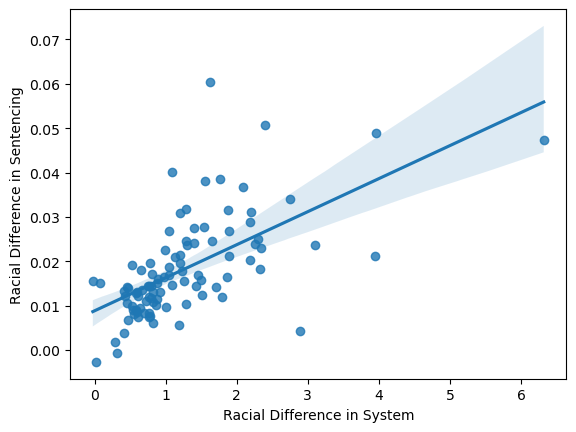

In [250]:
sns.regplot(x="weighted_rep_difference_b_w", y="normalized_diff", data=scatter2)
plt.xlabel('Racial Difference in System')
plt.ylabel('Racial Difference in Sentencing')